In [1]:
train_path = './data/train/hy_round1_train_20200102'
test_path = './data/testA'

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import math

In [3]:
def count_path(path,start_num = 0, file_nums = 7000, train=True):
    features = []
    i = 0
    for file in tqdm(range(start_num, start_num + file_nums)):
        feature = []
        df = pd.read_csv(os.path.join(path, '{}.csv'.format(file)))
        if train:
            fisher_type = df['type'][0]
            df = df.drop(['type'], axis=1)
        fisher_id = df['渔船ID'][0]
        df['time'] = df['time'].apply(lambda x: datetime.strptime(x, "%m%d %H:%M:%S")) # 格式化时间
        df_sub = df.diff(-1).iloc[0:-1]
        df = df.assign(
            month = df.time.dt.month,
            day = df.time.dt.day,
            hour = df.time.dt.hour, 
            minute = df.time.dt.minute,
            second = df.time.dt.second)
        
        # 原始数据的统计特征
        feature.append(df['x'].mean())
        feature.append(df['x'].max())
        feature.append(df['x'].min())
        feature.append(df['x'].std())
        feature.append(df['x'].median())
        
        feature.append(df['y'].mean())
        feature.append(df['y'].max())
        feature.append(df['y'].min())
        feature.append(df['y'].std())
        feature.append(df['y'].median())
        
        feature.append(df['速度'].mean())
        feature.append(df['速度'].max())
        feature.append(df['速度'].min())
        feature.append(df['速度'].std())
        feature.append(df['速度'].median())
        
        feature.append(df['方向'].mean())
        feature.append(df['方向'].std())
        
        # 速度为0的状态比例
        feature.append((df['速度'] == 0).mean())
        
        # x和y的协方差
        feature.append(df['x'].cov(df['y']))
        df_sub['distance'] = np.sqrt(df_sub['x'] ** 2 + df_sub['y']**2)
        feature.append(df_sub['distance'].mean())
        feature.append(df_sub['distance'].max())
        feature.append(df_sub['distance'].min())
        feature.append(df_sub['distance'].std())
        feature.append(df_sub['distance'].median())
        
        df_sub['avg_v'] = df_sub['distance'] / df_sub['time'].dt.total_seconds()
        
        feature.append(df_sub['avg_v'].mean())
        feature.append(df_sub['avg_v'].max())
        feature.append(df_sub['avg_v'].min())
        feature.append(df_sub['avg_v'].std())
        feature.append(df_sub['avg_v'].median())
        
        feature.append(df['x'].mode()[0]) # 停留最多的地方
        feature.append(df['y'].mode()[0])
        feature.append(int(df.groupby(['x']).size()[df['x'].mode()[0]])) # 这个地方的坐标上报次数
        feature.append(int(df.groupby(['y']).size()[df['y'].mode()[0]]))
        x_mode_group = df.groupby(['x']).get_group(df['x'].mode()[0])
        x_mode_time = (x_mode_group['time'].max() - x_mode_group['time'].min()).total_seconds() # 在这里停留的时长
        feature.append(x_mode_time)
        y_mode_group = df.groupby(['y']).get_group(df['y'].mode()[0])
        y_mode_time = (y_mode_group['time'].max() - y_mode_group['time'].min()).total_seconds()
        feature.append(y_mode_time)
        feature.append(x_mode_time / (df['time'].max()-df['time'].min()).total_seconds()) # 在这里停留时长占总时长的比例
        feature.append(y_mode_time / (df['time'].max()-df['time'].min()).total_seconds())
        
        x_mode = df['x'].mode()[0]
        y_mode = df['y'].mode()[0]
        if df[df['x'] != x_mode]['x'].size > 0:
            feature.append(df[df['x'] != x_mode]['x'].mode()[0]) # 停留第二久的地方
            feature.append(df[df['y'] != y_mode]['y'].mode()[0])
            feature.append(abs(x_mode - df[df['x'] != x_mode]['x'].mode()[0])) # 和停留最多的地方的差距
            feature.append(abs(y_mode - df[df['y'] != y_mode]['y'].mode()[0]))
        else:
            feature.append(x_mode)
            feature.append(y_mode)
            feature.append(0)
            feature.append(0)
            
        # 对停留的地方的处理
        feature.append(df.groupby(['x', 'y']).size().sum()) # 上报的位置个数
        feature.append(df[df['速度'] == 0].groupby(['x', 'y']).size().sum()) # 停留的位置个数
        feature.append(df[df['速度'] == 0].groupby(['x', 'y']).size().sum() / df.groupby(['x', 'y']).size().sum()) # 停留位置的比例


        if train:
            if fisher_type == '拖网':
                feature.append(0)
            elif fisher_type == '围网':
                feature.append(1)
            elif fisher_type == '刺网':
                feature.append(2)
        features.append(feature)
    return features

In [4]:
train_features = count_path(train_path)
test_features = count_path(test_path, start_num=7000, file_nums=2000, train=False)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:24<00:00, 23.77it/s]


In [5]:
features_name = ['x_mean', 'x_max', 'x_min', 'x_std', 'x_median', 
                 'y_mean', 'y_max', 'y_min', 'y_std', 'y_median',
                 'v_mean', 'v_max', 'v_min', 'v_std', 'v_median',
                 'd_mean', 'd_std', 'zero_per', 'xy_cov', 
                 'dis_mean', 'dis_max', 'dis_min', 'dis_std', 'dis_median',
                 'av_mean', 'av_max', 'av_min', 'av_std', 'av_median', 'x_mode', 'y_mode', 
                 'x_mode_count', 'y_mode_count', 'x_mode_time', 'y_mode_time', 'x_mode_tper', 'y_mode_tper',
                 'x_mode_2', 'y_mode_2', 'x_mode_sub', 'y_mode_sub', 
                 'pos', 'stay_pos', 'stay_per']
train_df = pd.DataFrame(np.array(train_features).reshape(7000, -1))
train_df.columns = features_name + ['type']
test_df = pd.DataFrame(np.array(test_features).reshape(2000, -1))
test_df.columns = features_name
print(train_df.shape, test_df.shape)

(7000, 45) (2000, 44)


In [6]:
pd.set_option('display.max_columns', 30)
train_df.head(13)

,x_mean,x_max,x_min,x_std,x_median,y_mean,y_max,y_min,y_std,y_median,v_mean,v_max,v_min,v_std,v_median,...,y_mode,x_mode_count,y_mode_count,x_mode_time,y_mode_time,x_mode_tper,y_mode_tper,x_mode_2,y_mode_2,x_mode_sub,y_mode_sub,pos,stay_pos,stay_per,type
0,6.119351e+06,6.152038e+06,6.118352e+06,5.037321e+03,6.118352e+06,5.130494e+06,5.130781e+06,5.124873e+06,850.264541,5.130672e+06,0.265966,9.39,0.00,1.321248,0.000,...,5.130672e+06,391.0,391.0,244789.0,244789.0,0.946846,0.946846,6.118453e+06,5.130670e+06,101.686330,2.528671,414.0,369.0,0.891304,0.0
1,6.091460e+06,6.102450e+06,6.049472e+06,1.654339e+04,6.102450e+06,5.094050e+06,5.112874e+06,5.042857e+06,26764.042729,5.112760e+06,1.607922,10.47,0.00,2.412688,0.050,...,5.112760e+06,246.0,246.0,167392.0,167392.0,0.648839,0.648839,6.102348e+06,5.112762e+06,101.804823,2.688880,385.0,131.0,0.340260,0.0
2,6.183011e+06,6.183191e+06,6.182482e+06,2.078696e+02,6.183090e+06,5.193682e+06,5.193696e+06,5.193576e+06,21.740609,5.193685e+06,0.595150,50.46,0.00,3.415824,0.220,...,5.193685e+06,189.0,189.0,238831.0,238831.0,0.926790,0.926790,6.182482e+06,5.193696e+06,607.572811,11.304855,233.0,54.0,0.231760,0.0
3,5.239159e+06,5.287805e+06,5.228590e+06,1.750371e+04,5.229843e+06,4.601532e+06,4.608628e+06,4.577467e+06,11590.605179,4.608404e+06,1.471343,10.09,0.00,2.528593,0.220,...,4.608404e+06,160.0,160.0,250484.0,250484.0,0.972002,0.972002,5.229849e+06,4.608510e+06,6.608276,106.174957,335.0,70.0,0.208955,0.0
4,7.062005e+06,7.070797e+06,7.049394e+06,5.979579e+03,7.061679e+06,6.116389e+06,6.136033e+06,6.094996e+06,12055.148984,6.116621e+06,1.412219,10.09,0.00,2.496836,0.320,...,6.114141e+06,17.0,17.0,9598.0,9598.0,0.037053,0.037053,7.070704e+06,6.118895e+06,9953.988150,4753.822864,401.0,61.0,0.152120,1.0
5,6.488945e+06,6.503900e+06,6.388833e+06,2.227176e+04,6.496570e+06,5.576252e+06,5.603770e+06,5.340338e+06,62867.041759,5.603540e+06,1.713813,10.09,0.00,3.105356,0.220,...,5.603540e+06,168.0,168.0,134565.0,134565.0,0.520748,0.520748,6.496575e+06,5.602988e+06,5.844307,551.876901,375.0,79.0,0.210667,0.0
6,6.058099e+06,6.079949e+06,6.032505e+06,1.133196e+04,6.058808e+06,5.028613e+06,5.047377e+06,5.004409e+06,12271.199509,5.031125e+06,3.750787,6.75,0.86,0.784521,3.780,...,5.039607e+06,2.0,2.0,5399.0,184188.0,0.020879,0.712289,6.070487e+06,5.042083e+06,2815.114428,2475.915264,394.0,0.0,0.000000,0.0
7,6.759621e+06,6.986976e+06,6.587996e+06,1.364847e+05,6.811245e+06,5.805508e+06,5.814691e+06,5.785242e+06,7062.945568,5.807560e+06,4.487529,13.49,0.00,4.217782,2.805,...,5.812012e+06,52.0,52.0,32398.0,32398.0,0.150420,0.150420,6.588193e+06,5.813085e+06,1562.269958,1072.468492,348.0,52.0,0.149425,1.0
8,6.201416e+06,6.215849e+06,6.181299e+06,8.892414e+03,6.203378e+06,5.139750e+06,5.166370e+06,5.101720e+06,15473.350143,5.142446e+06,3.341366,8.20,0.00,1.279559,3.510,...,5.139782e+06,3.0,3.0,84101.0,84101.0,0.325549,0.325549,6.195261e+06,5.146616e+06,8422.806924,6834.214957,366.0,1.0,0.002732,0.0
9,6.102853e+06,6.102853e+06,6.102853e+06,9.324977e-10,6.102853e+06,5.112531e+06,5.112531e+06,5.112531e+06,0.000000,5.112531e+06,0.012519,0.16,0.00,0.027956,0.000,...,5.112531e+06,397.0,397.0,258586.0,258586.0,1.000000,1.000000,6.102853e+06,5.112531e+06,0.000000,0.000000,397.0,313.0,0.788413,0.0


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Simhei']
plt.style.use('ggplot')
def plot_feature(df, col1, col2, x_d=0, x_u=1, y_d=0, y_u=1):
    plt.figure(dpi=700,figsize=(3,2))
    col_data1 = df[col1].values
    col_data2 = df[col2].values
    fisher_types = df['type'].values
    colors = ['g', 'r', 'c']
    alphas=[1, 0.7, 0.4]
    categories = [0, 1, 2]
    labels = ['拖网','围网','刺网']
    for i in range(3):
        plt.scatter(col_data1[fisher_types==categories[i]], 
                    col_data2[fisher_types==categories[i]],
                    c = colors[i],
                    label = labels[i],
                    s = 2)
    plt.xticks(fontsize=3)
    plt.yticks(fontsize=3,rotation=90)
    plt.grid(alpha=0.2)
    plt.legend(fontsize=3)
    plt.xlabel(col1,fontsize=4)
    plt.ylabel(col2,fontsize=4)
    plt.xlim(df[col1].quantile(x_d),df[col1].quantile(x_u))
    plt.ylim(df[col2].quantile(x_d),df[col2].quantile(x_u))
    plt.show()

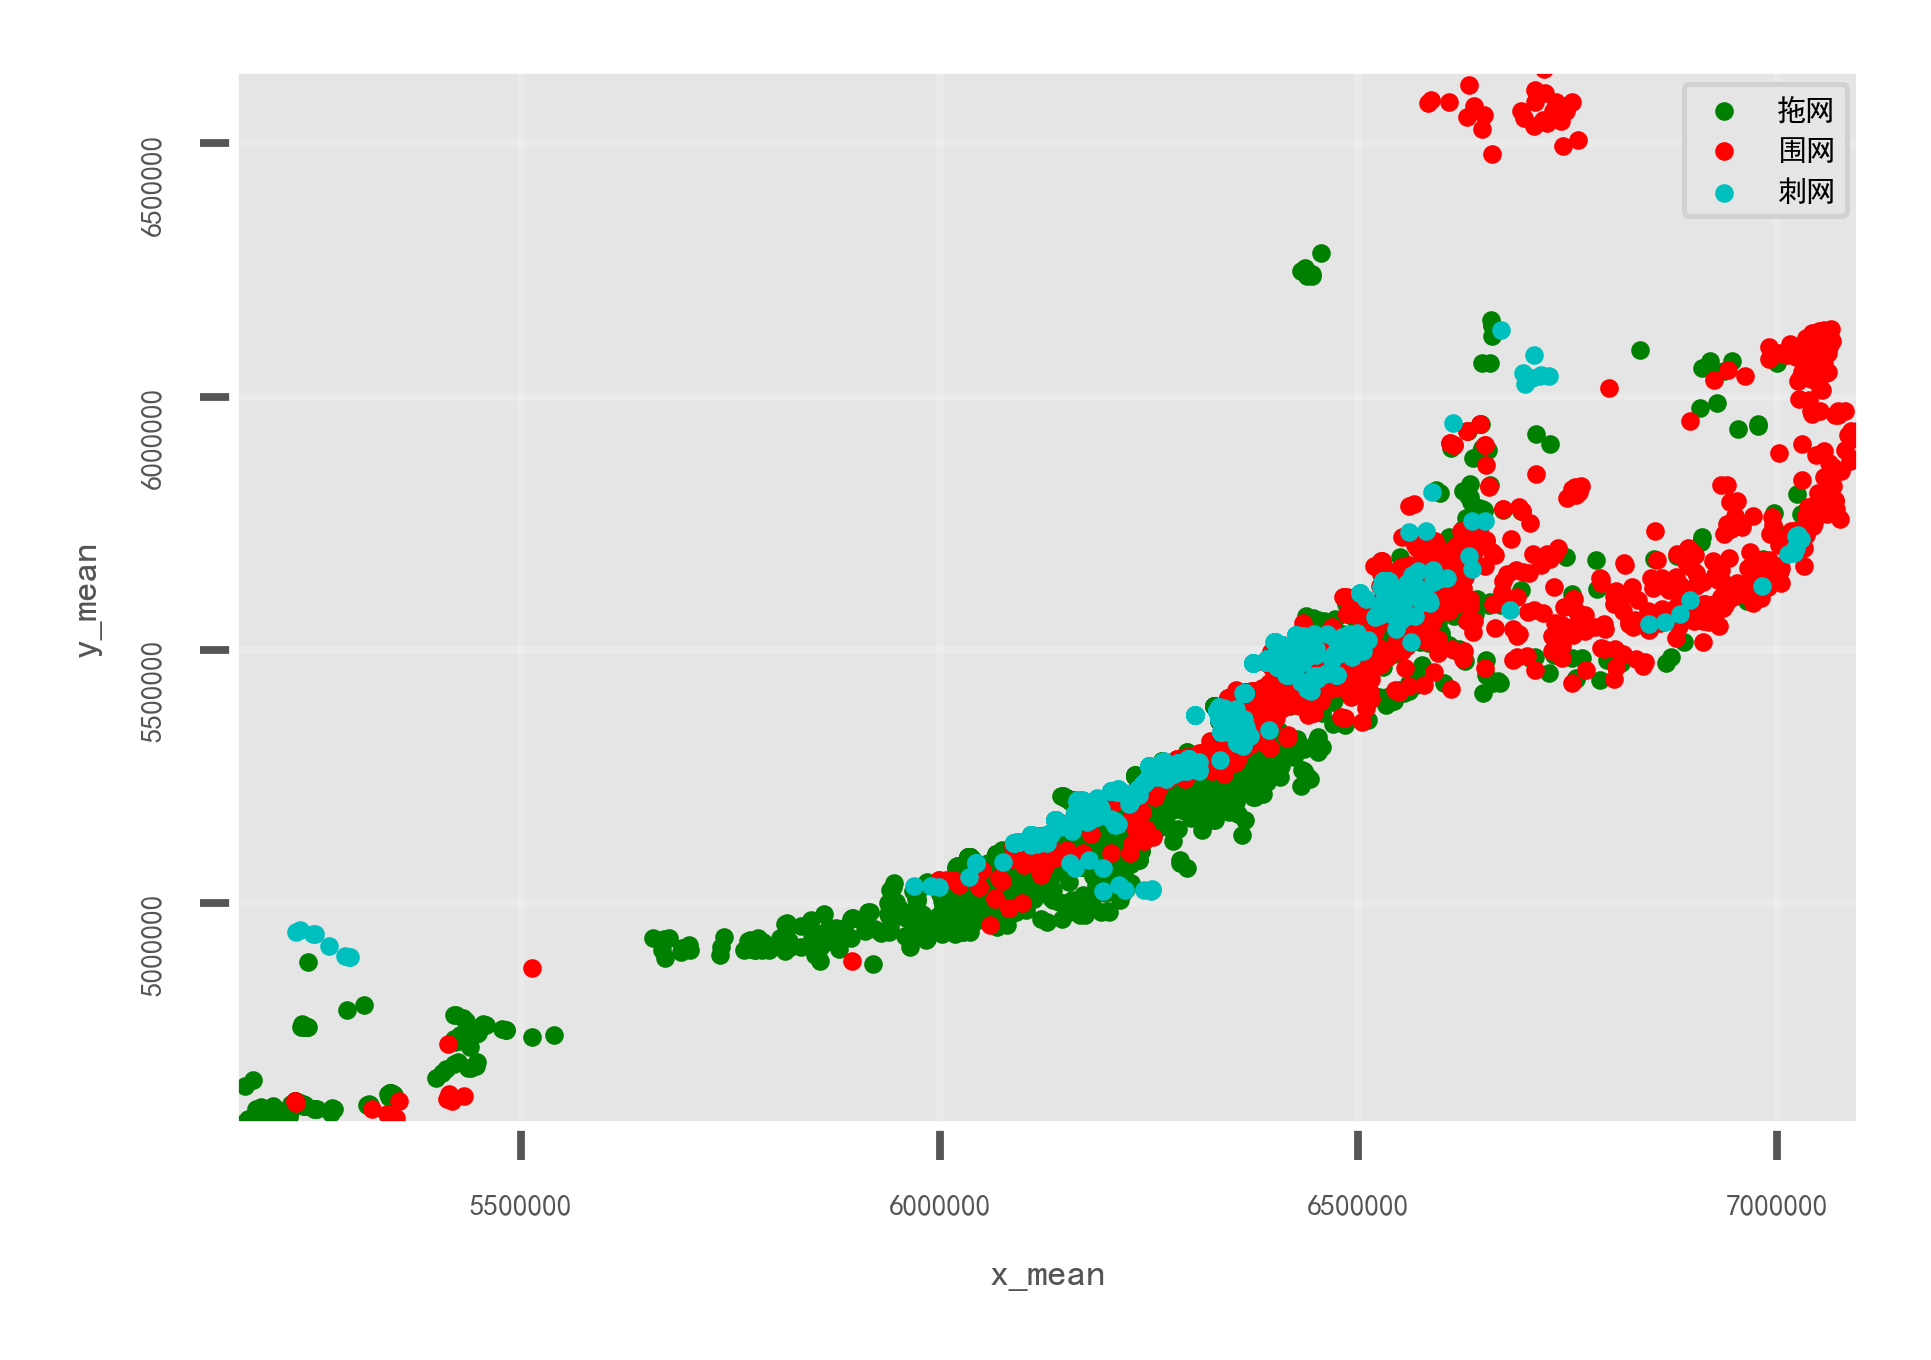

In [8]:
plot_feature(train_df, 'x_mean', 'y_mean')

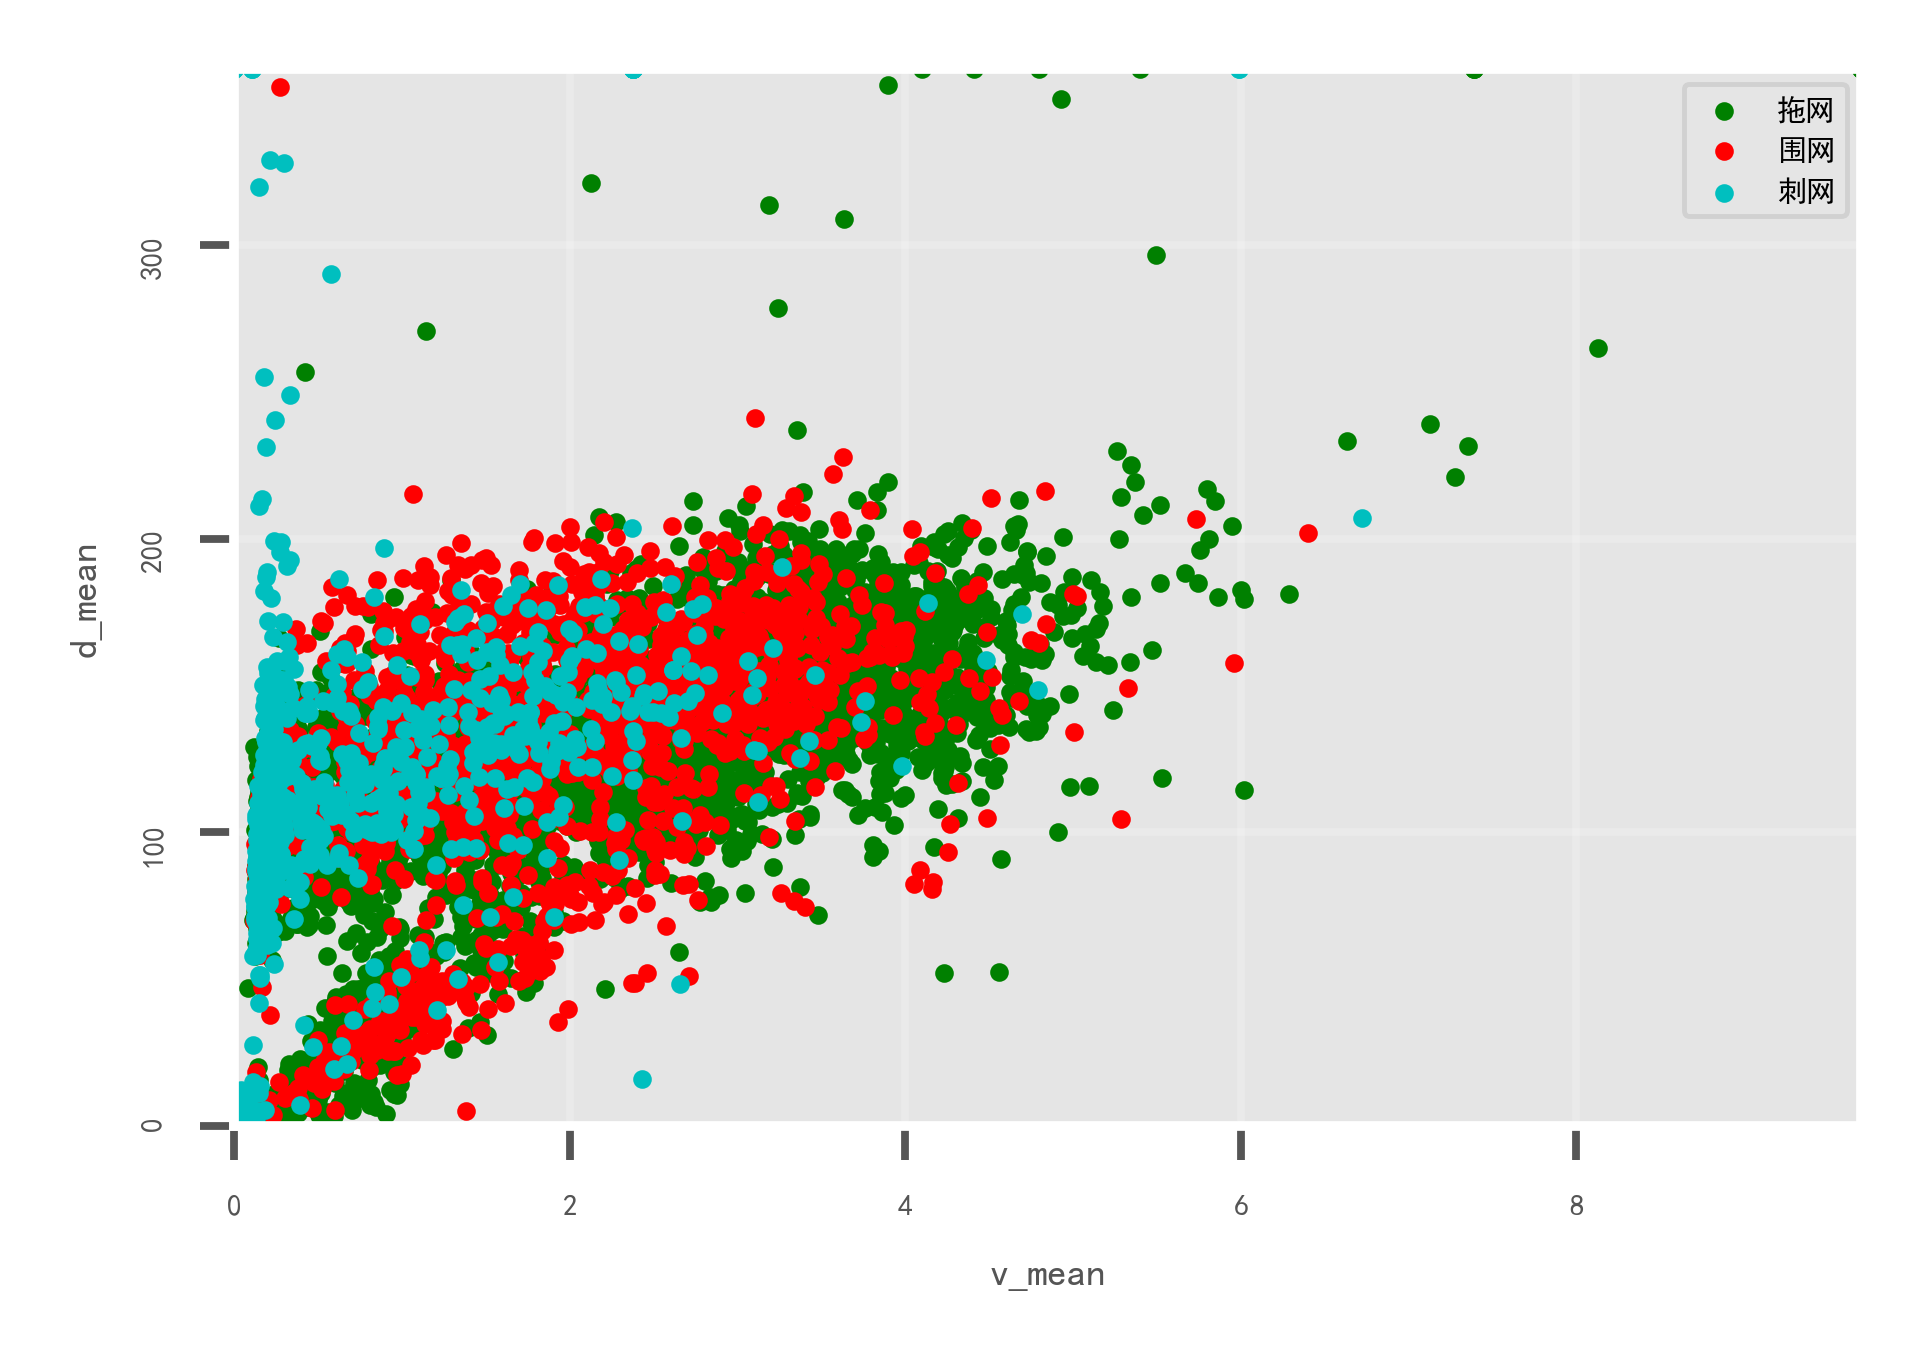

In [9]:
plot_feature(train_df, 'v_mean', 'd_mean')

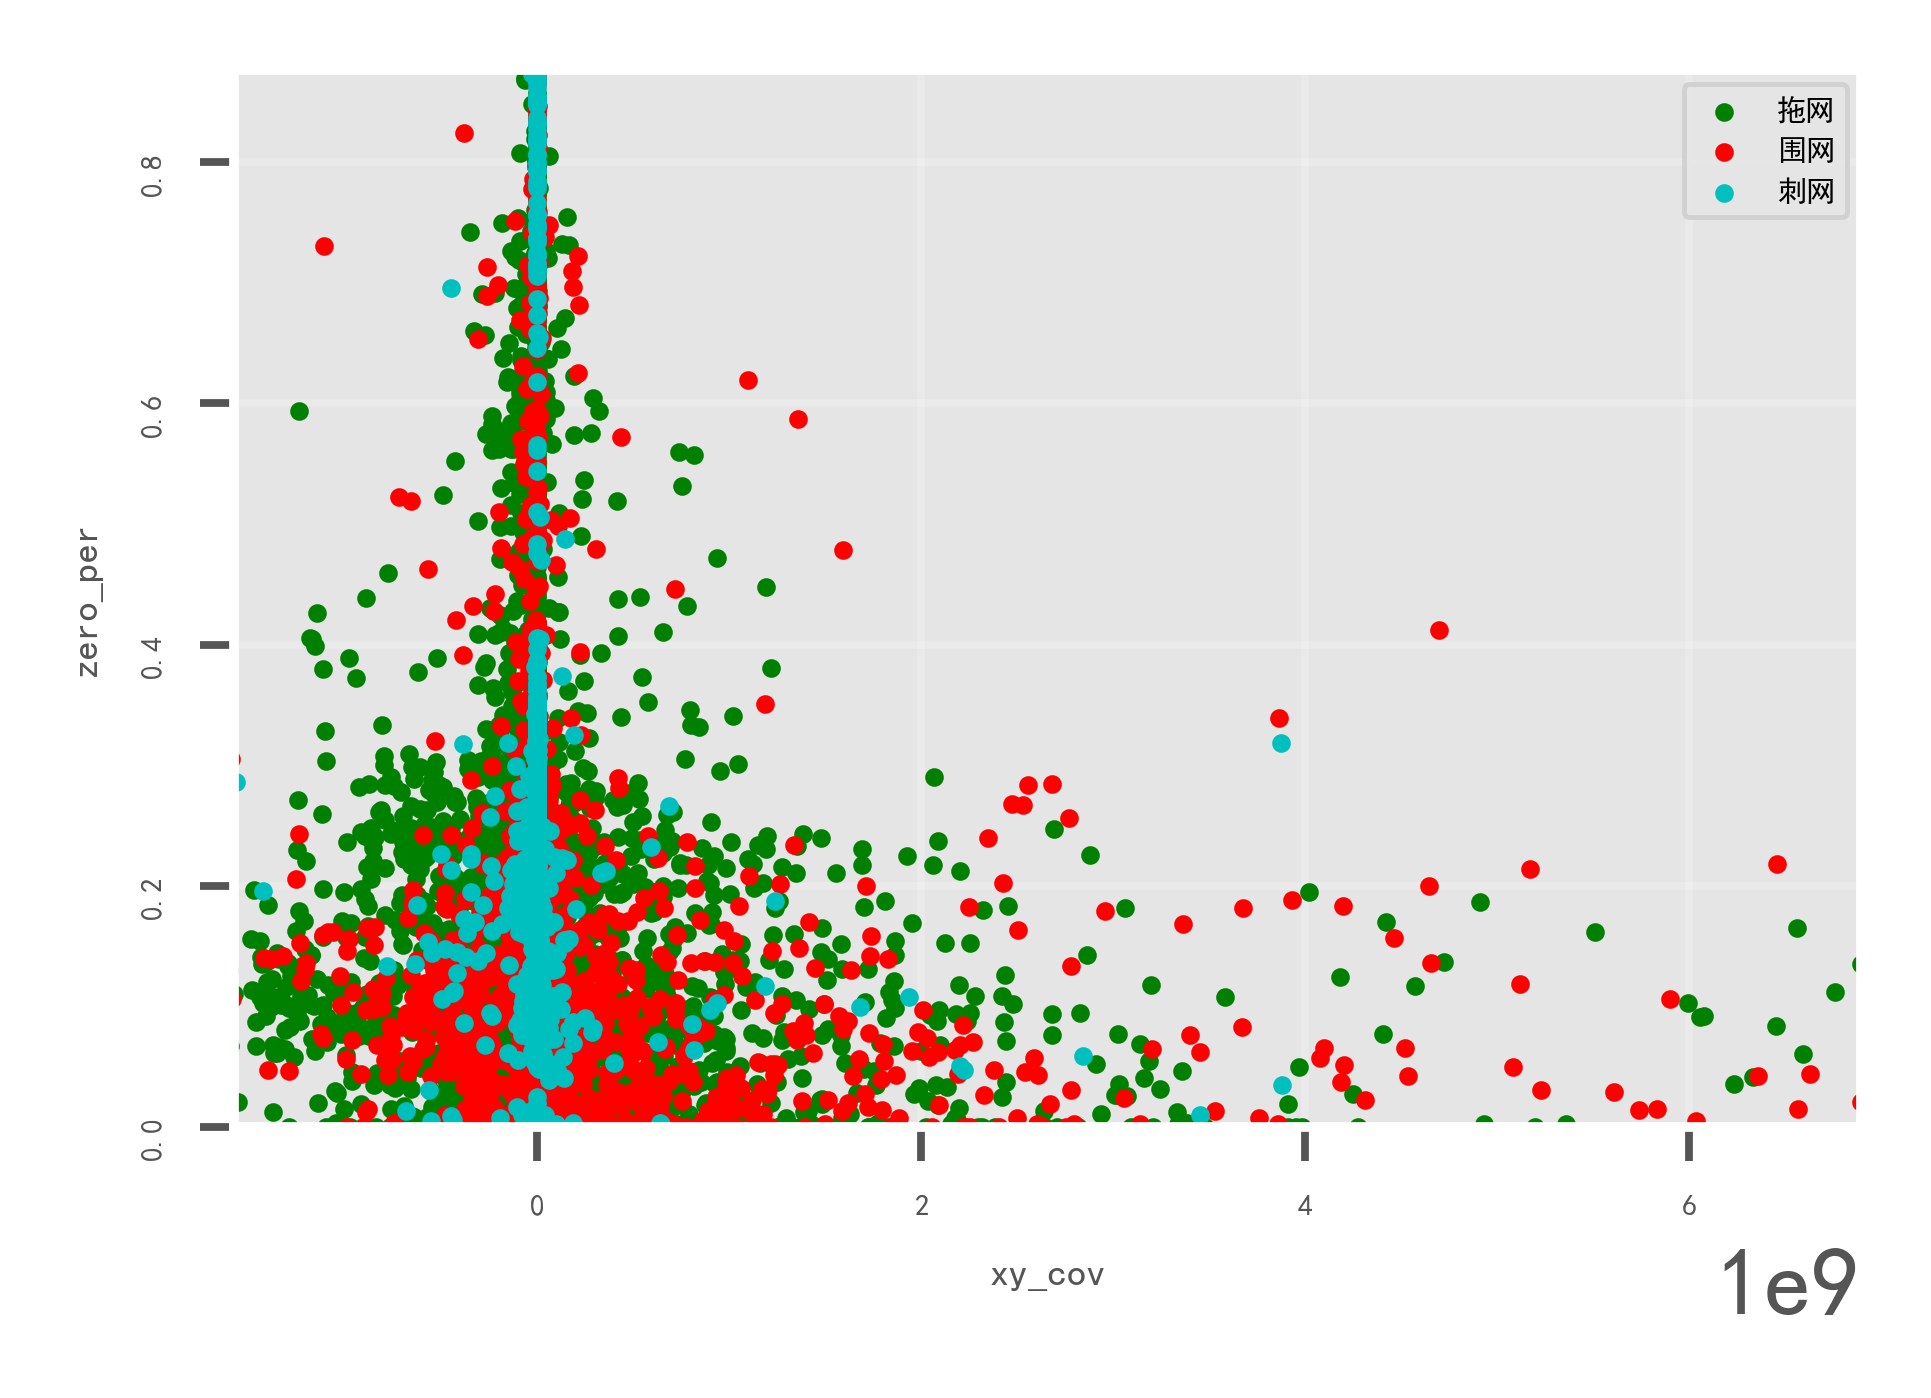

In [10]:
plot_feature(train_df, 'xy_cov', 'zero_per', x_d=0.01, x_u=0.99)

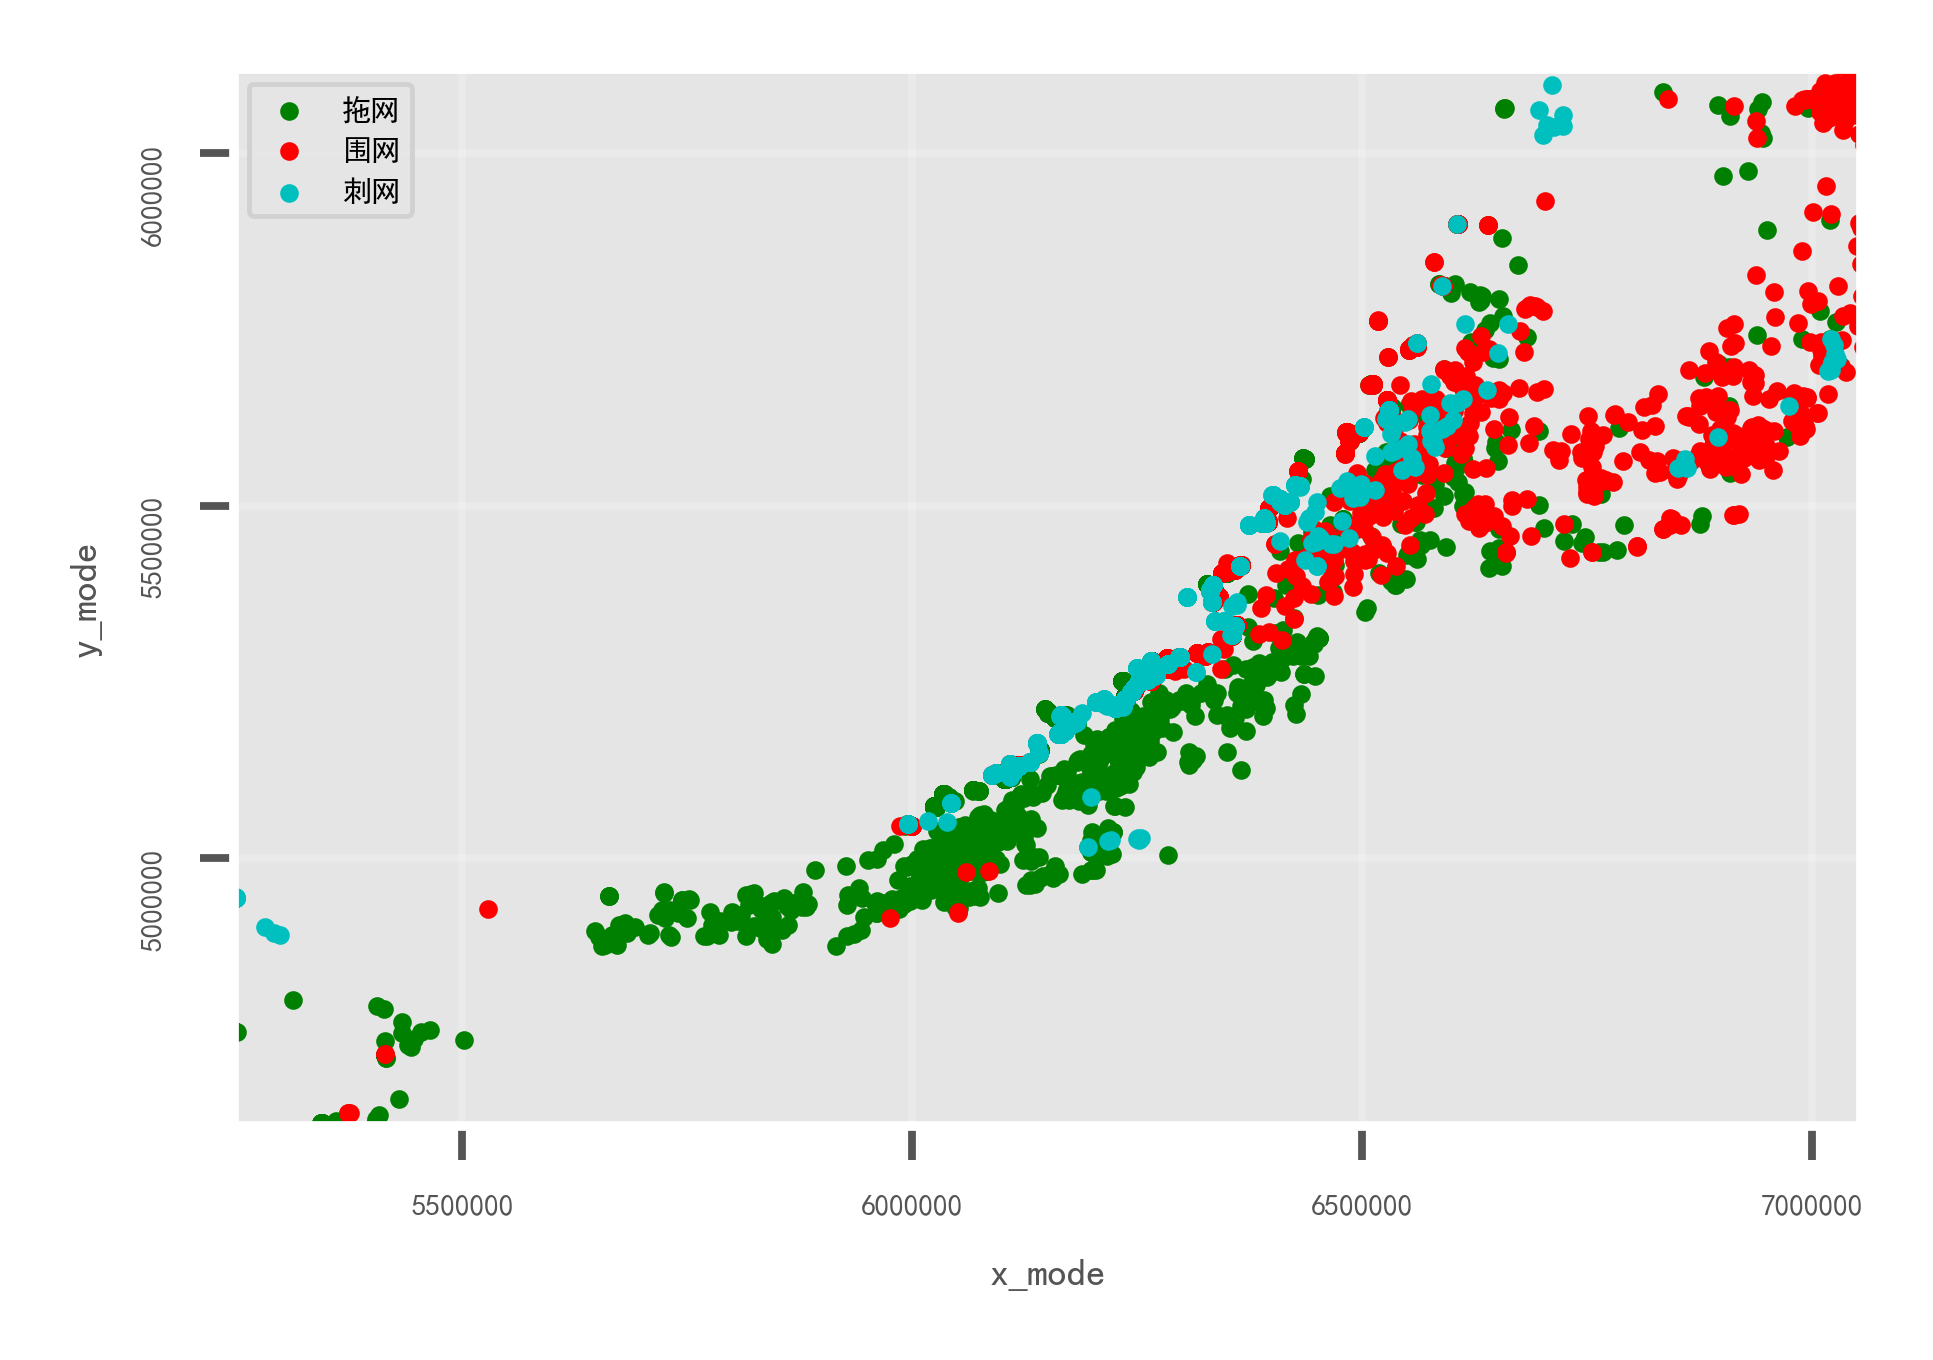

In [11]:
plot_feature(train_df, 'x_mode', 'y_mode', x_d=0.01, x_u=0.99)

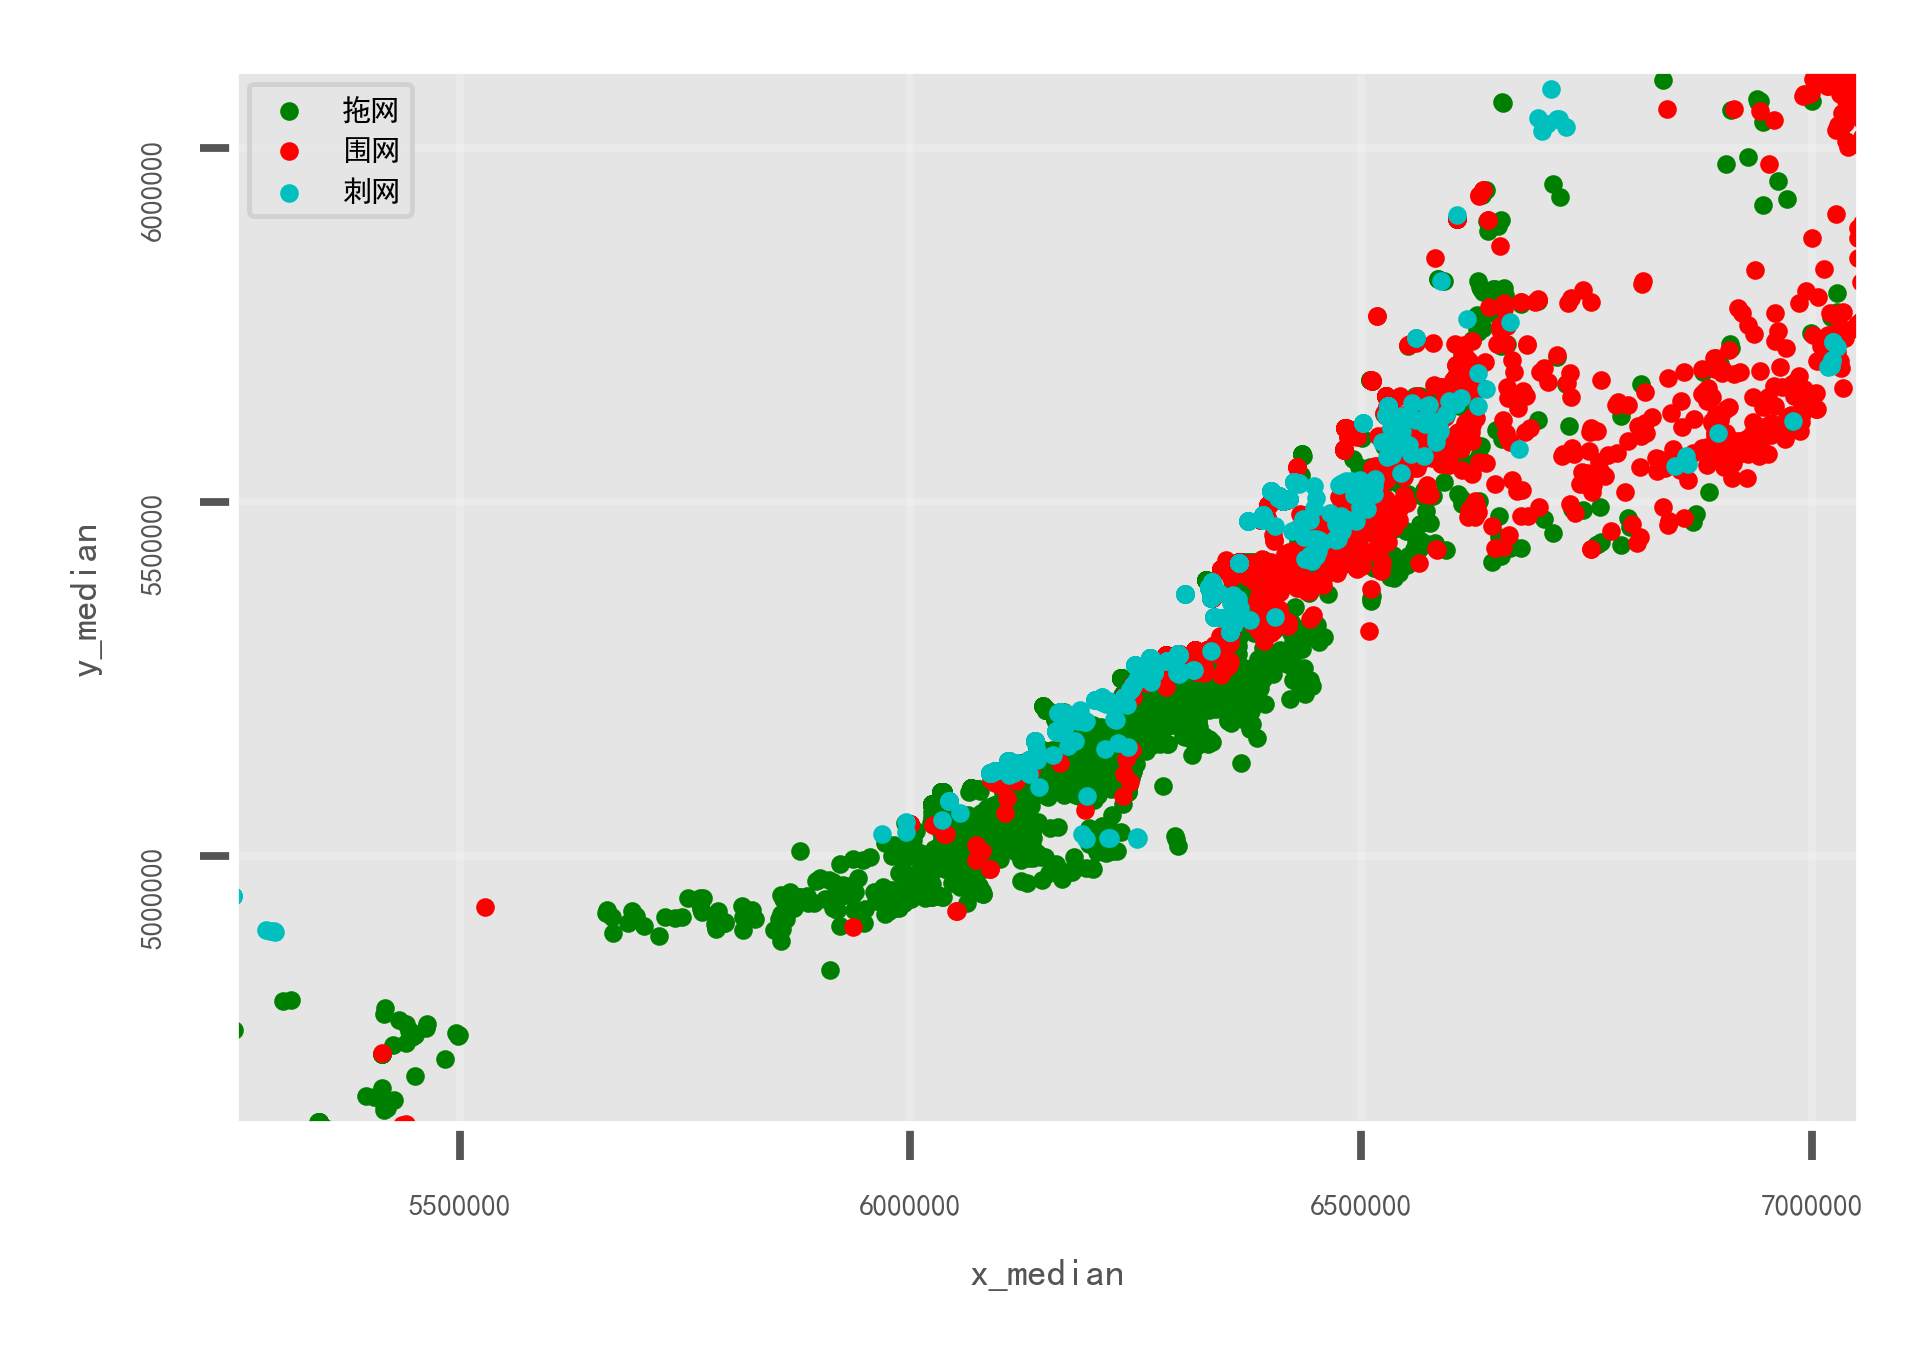

In [12]:
plot_feature(train_df, 'x_median', 'y_median', x_d=0.01, x_u=0.99)

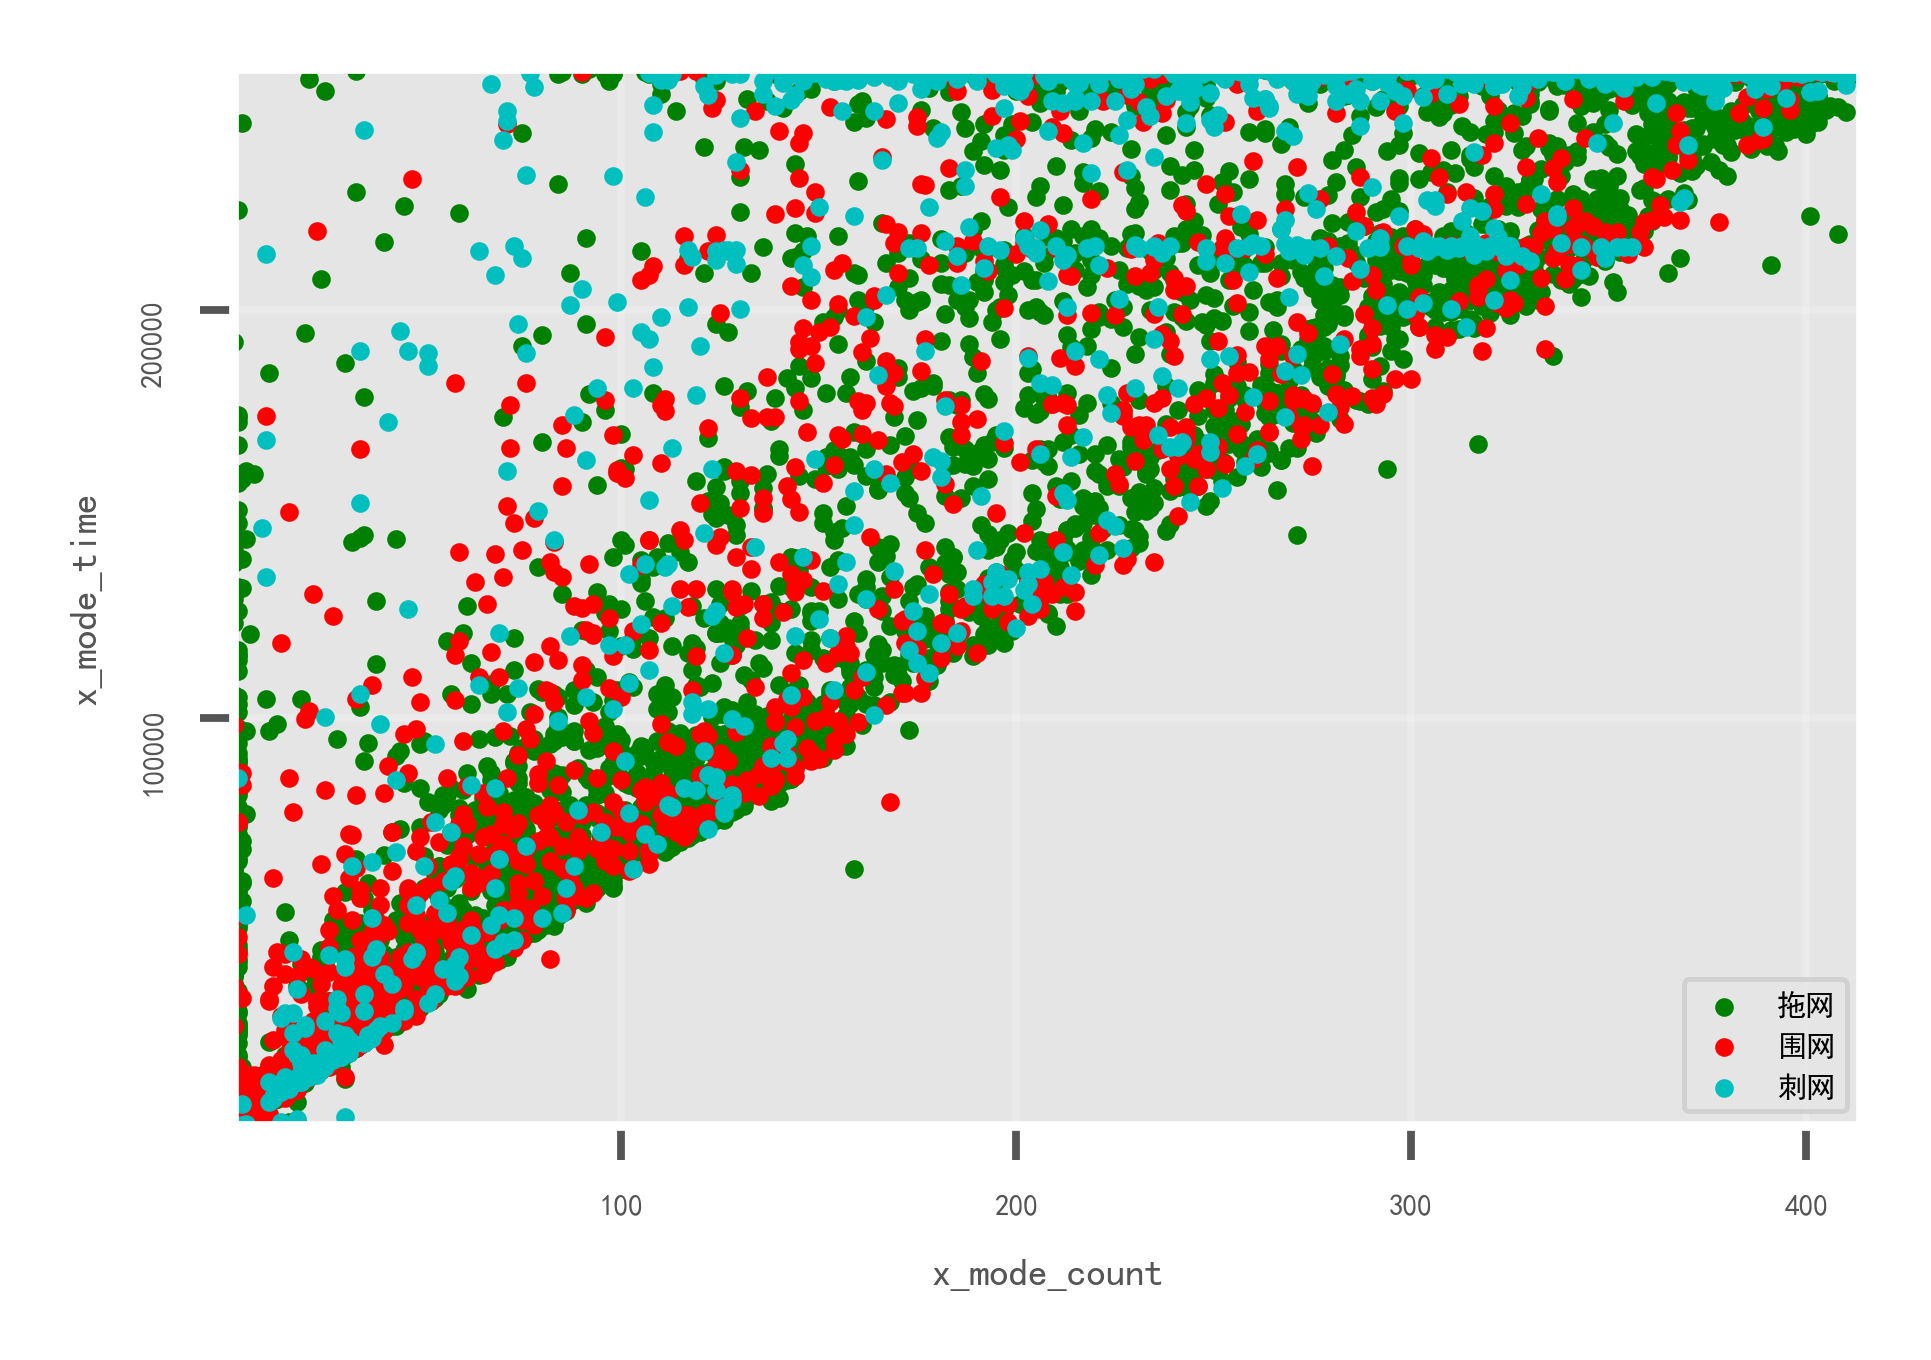

In [13]:
plot_feature(train_df, 'x_mode_count', 'x_mode_time', x_d=0.01, x_u=0.99)

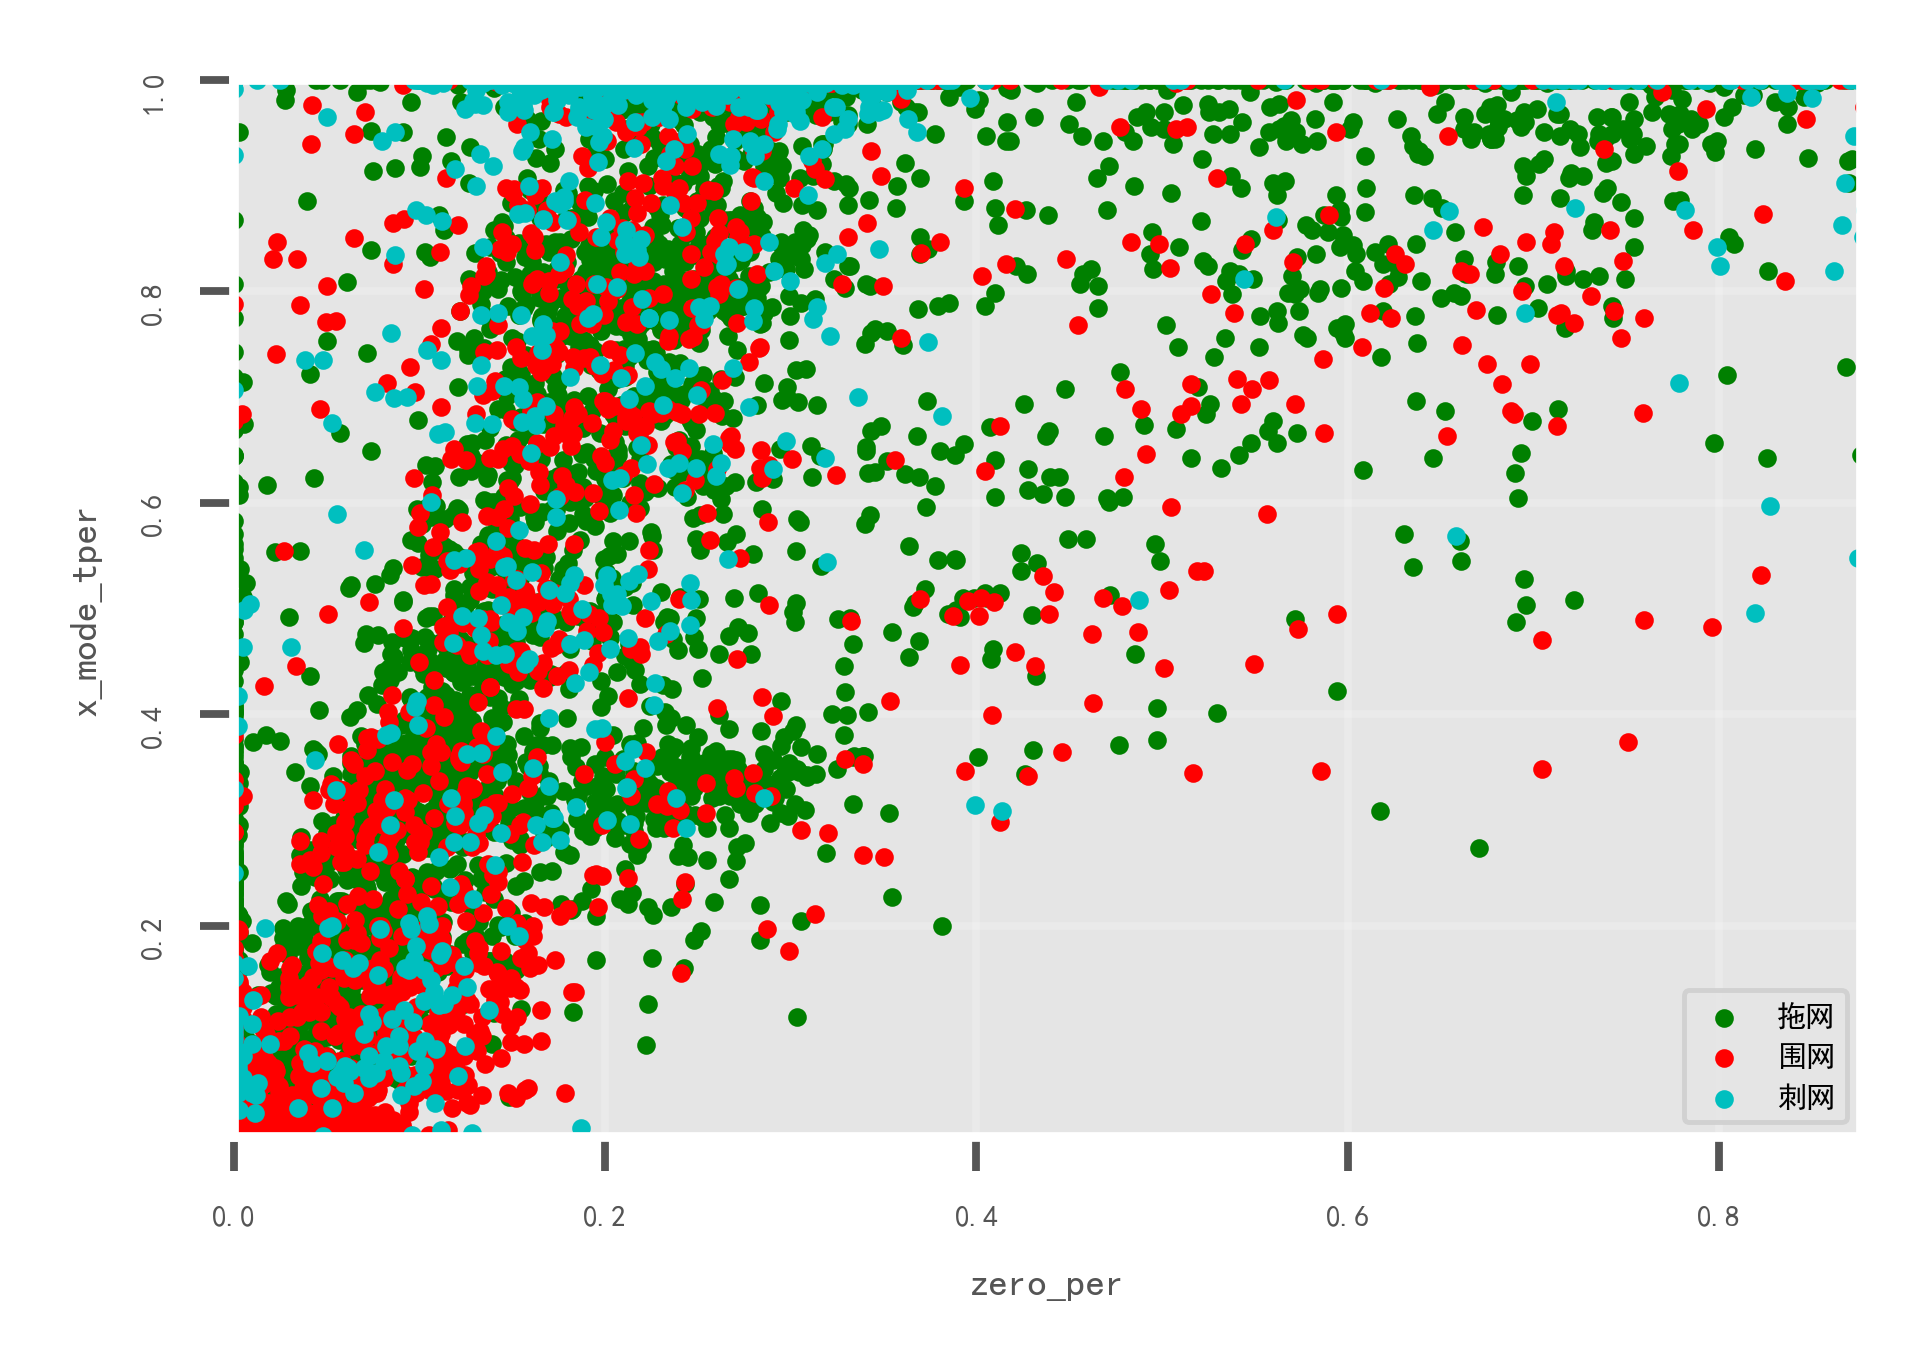

In [14]:
plot_feature(train_df, 'zero_per', 'x_mode_tper', x_d=0.01, x_u=0.99)

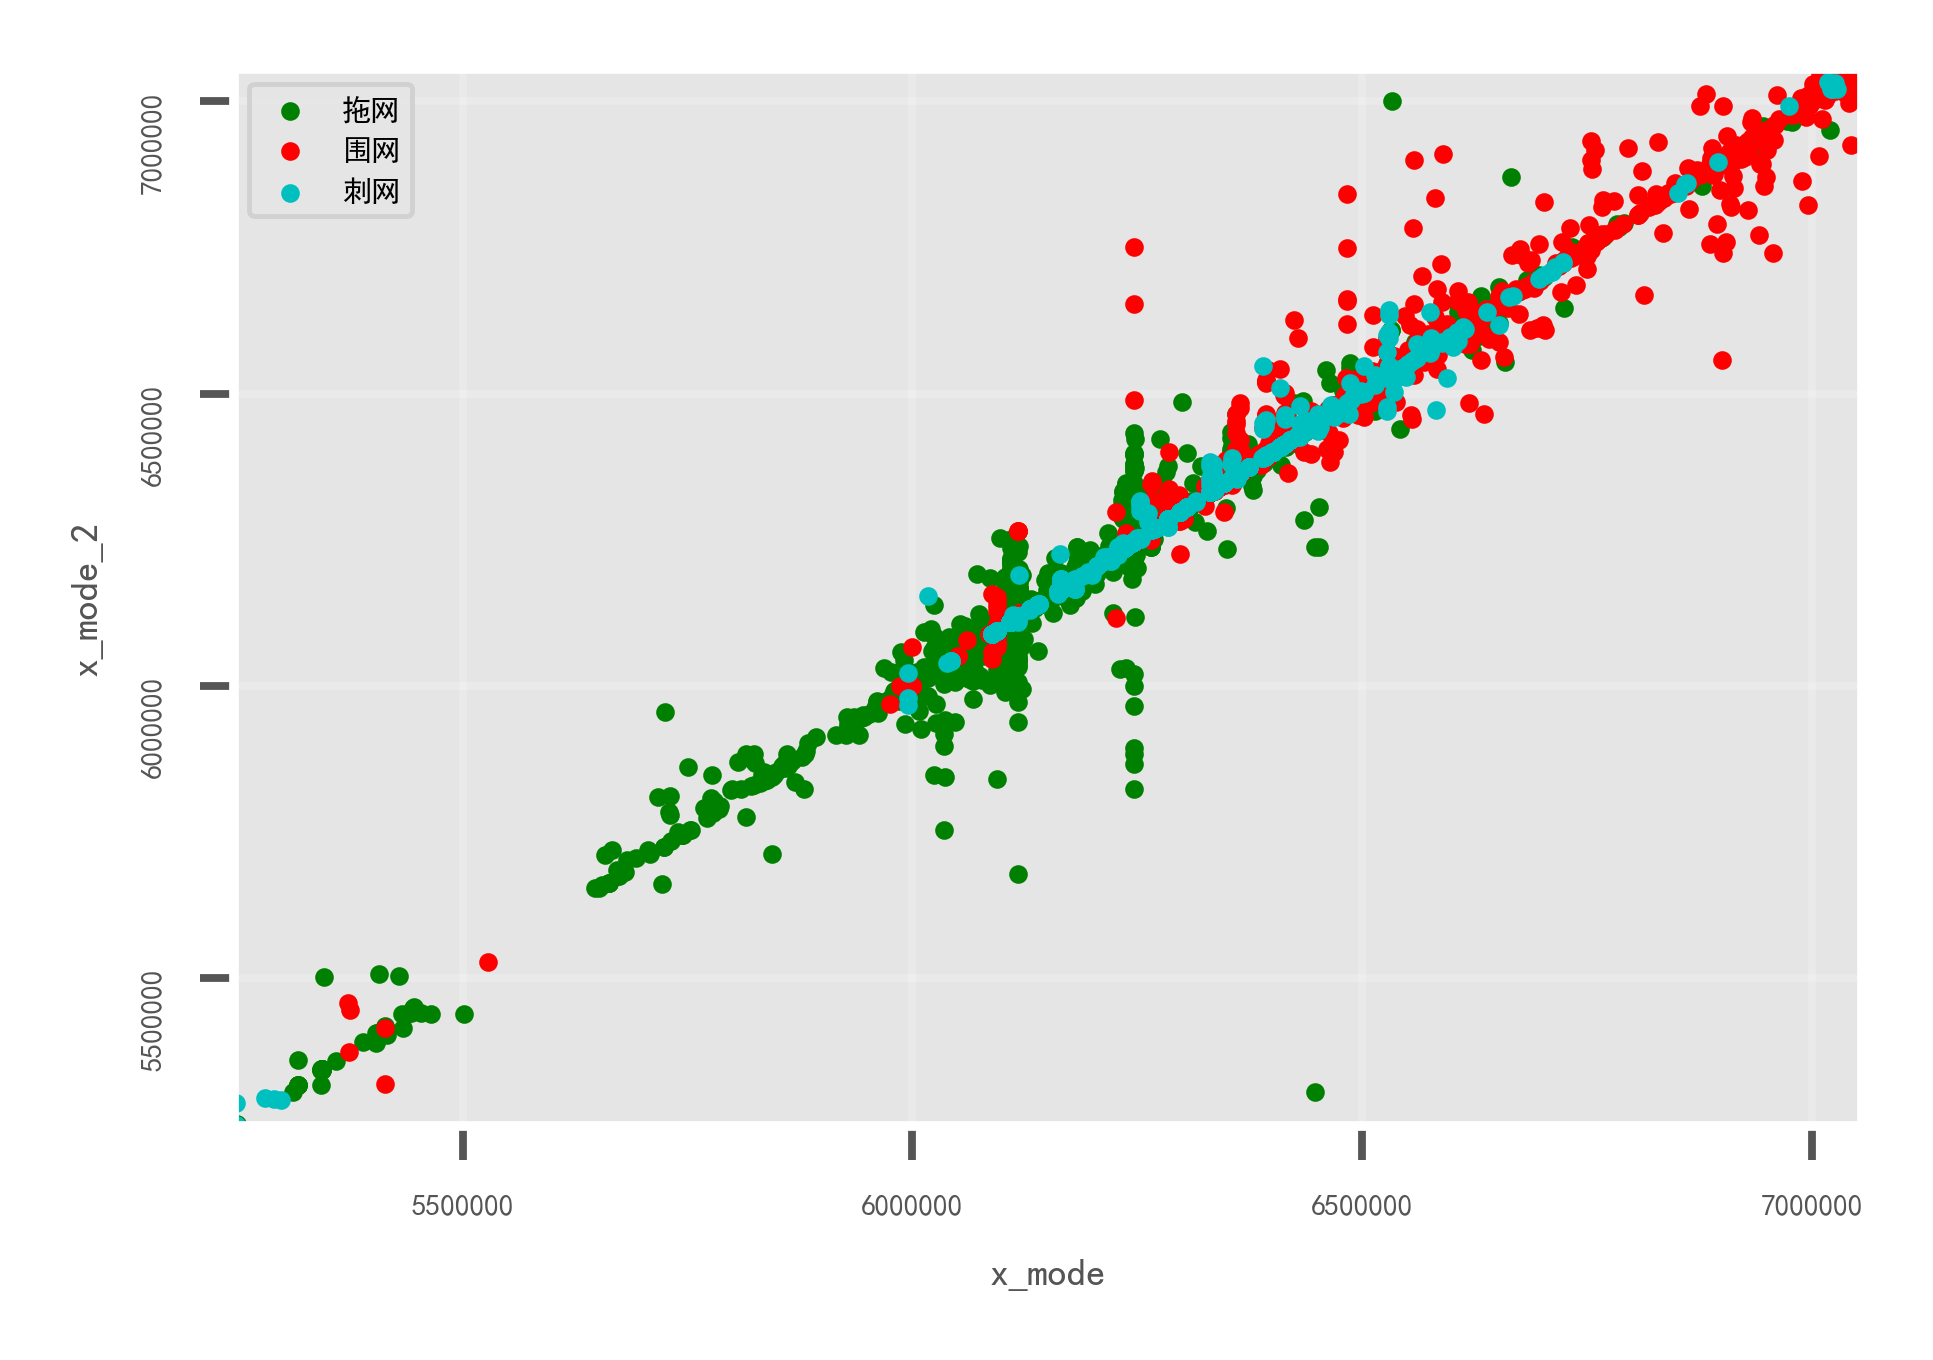

In [15]:
plot_feature(train_df, 'x_mode', 'x_mode_2', x_d=0.01, x_u=0.99)

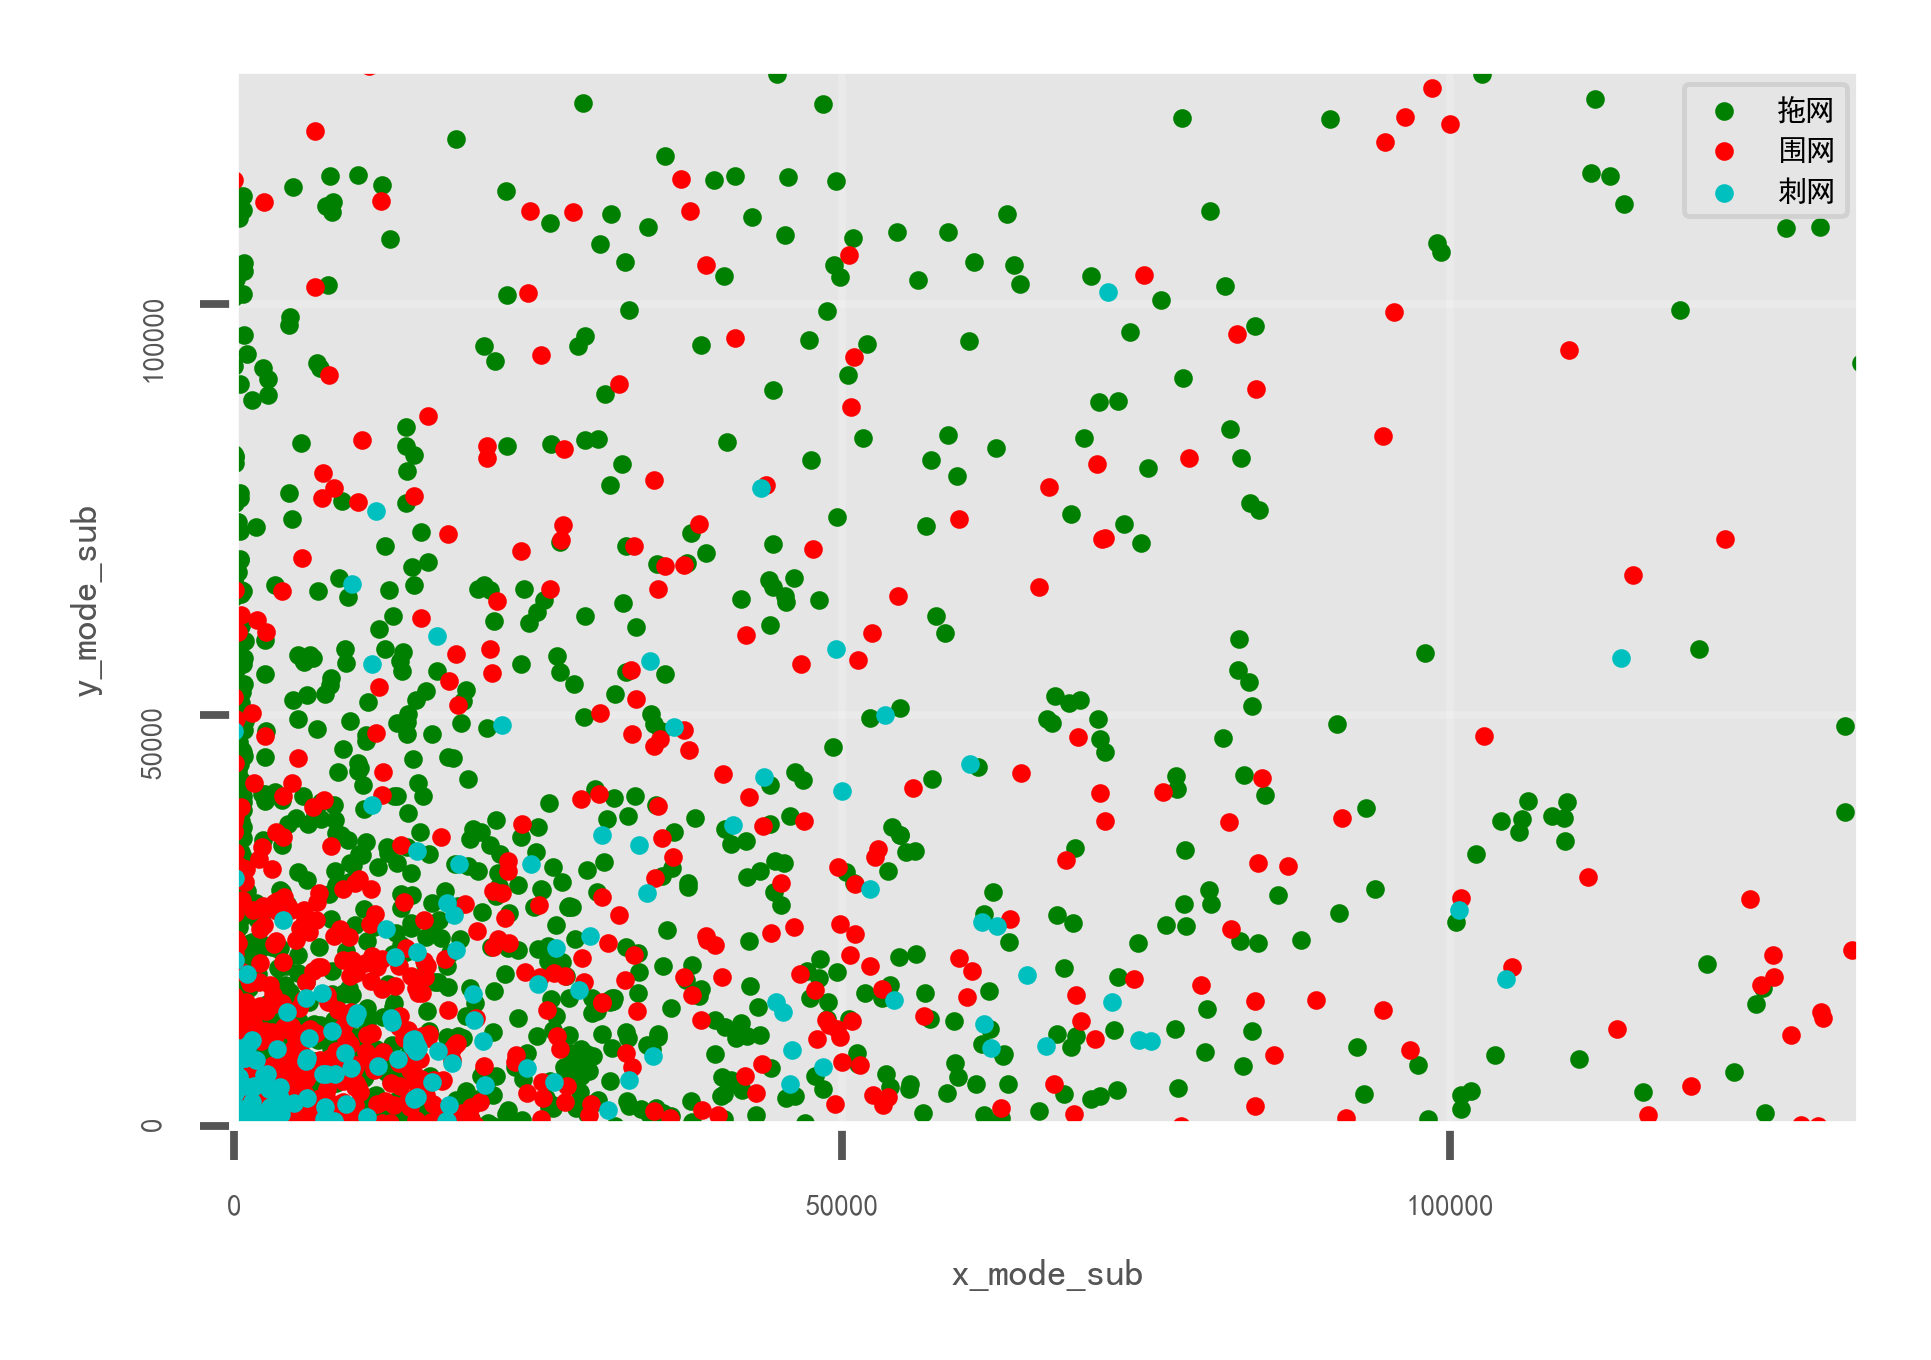

In [16]:
plot_feature(train_df, 'x_mode_sub', 'y_mode_sub', x_d=0.01, x_u=0.99)

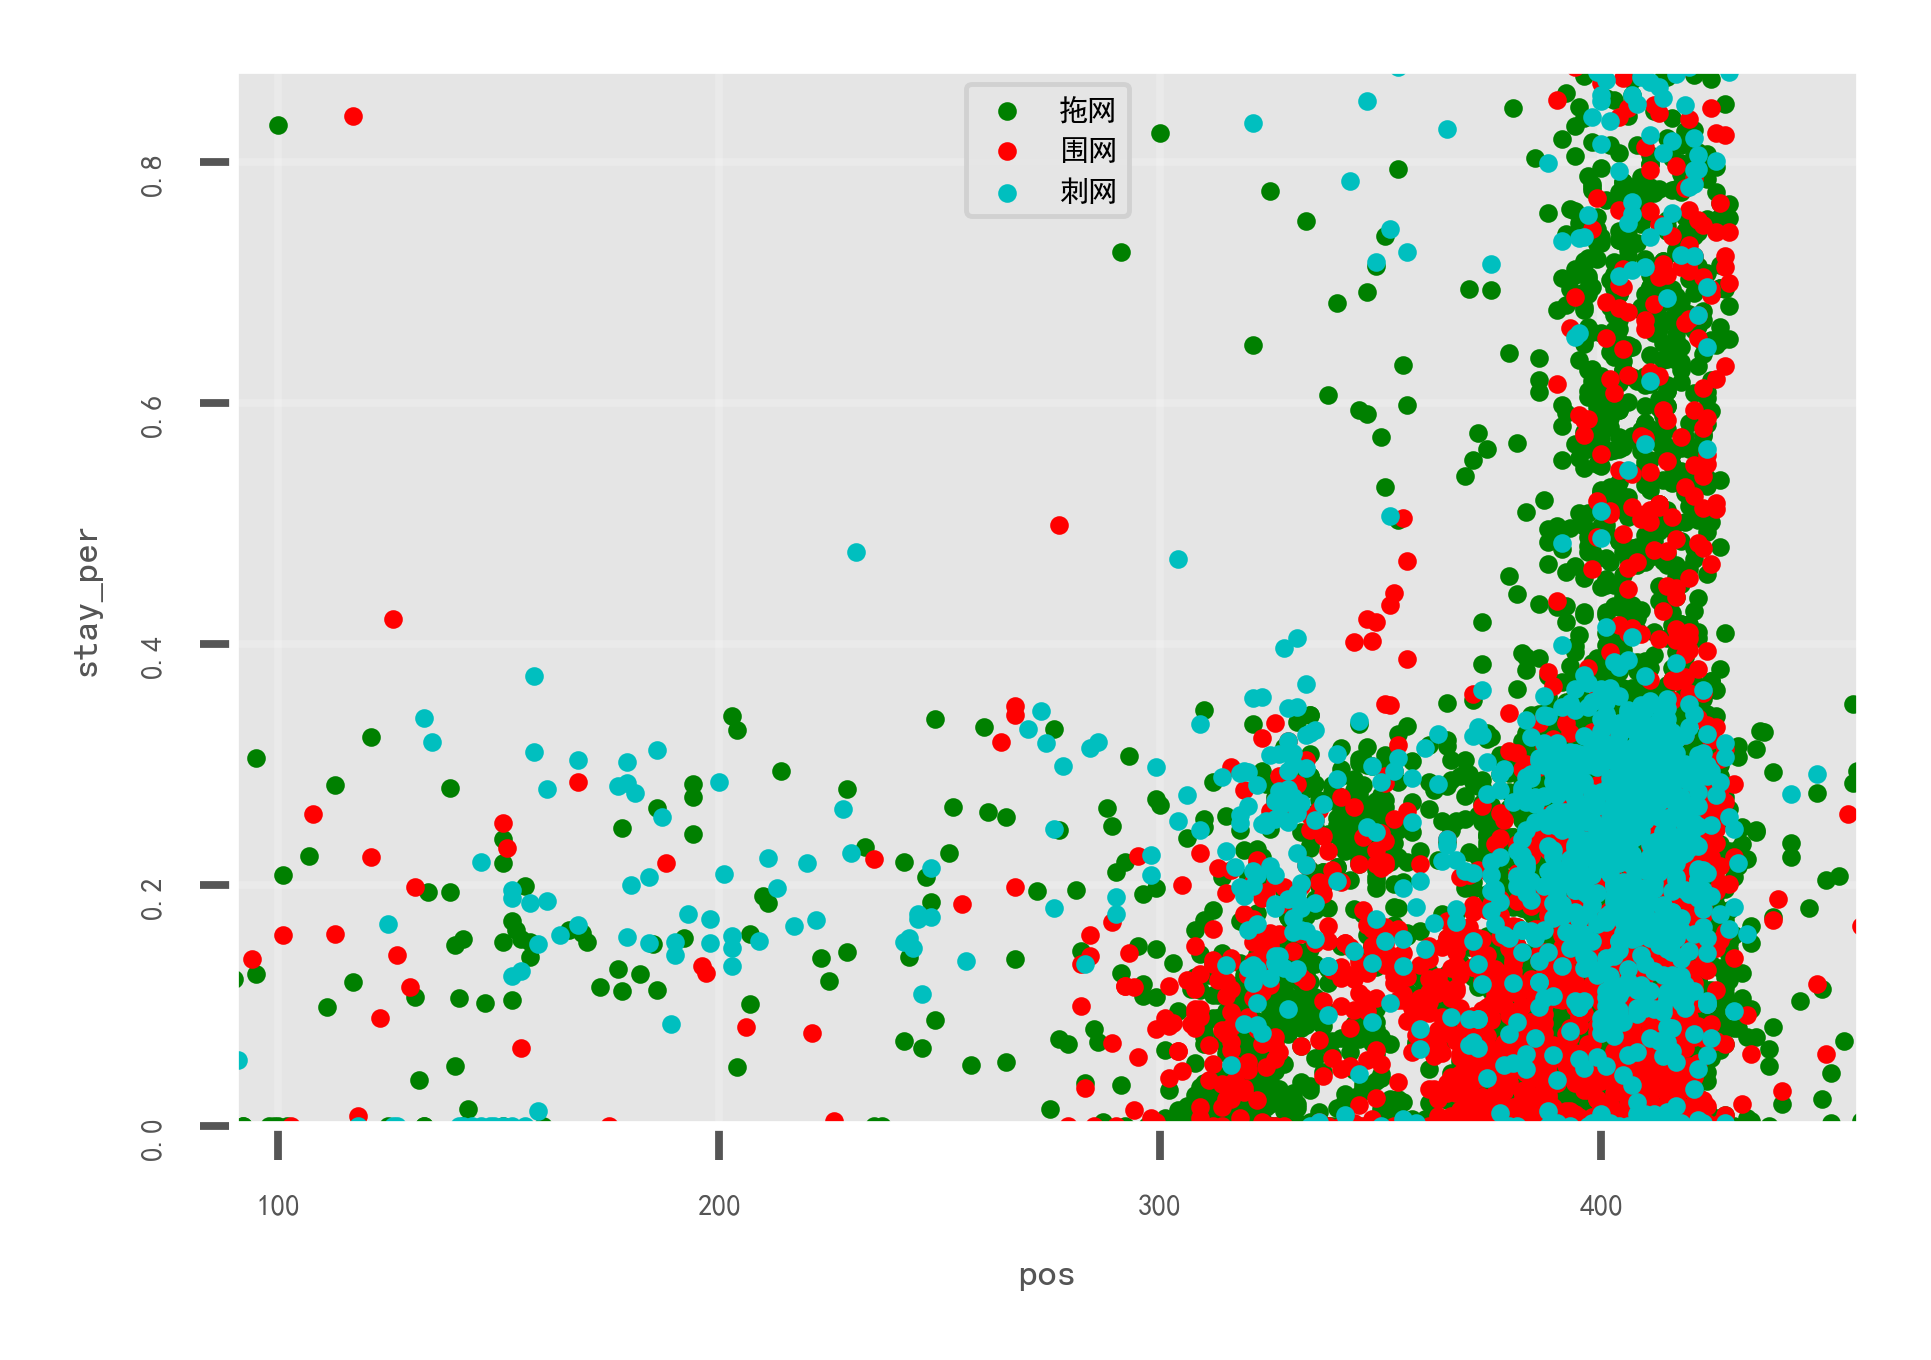

In [17]:
plot_feature(train_df, 'pos', 'stay_per', x_d=0.01, x_u=0.99)

In [18]:
from sklearn.model_selection import train_test_split
X_train = train_df[features_name].values
y_train = train_df['type'].values
X_test = test_df.values
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1998)

In [19]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
lgb_clf=LGBMClassifier(num_leaves=15
                       ,max_depth=8
                       ,learning_rate=0.39
                       ,n_estimators=180
                       ,class_weight={0:2.5,1:3,2:4.5}
                       ,objective='multiclass'
                       ,n_jobs=-1
                       ,reg_alpha=0
                       ,reg_lambda=0)
lgb_clf.fit(X_train, y_train,eval_set = (X_val, y_val), verbose = 10)
val_pred = lgb_clf.predict(X_val)
print('F1:', f1_score(y_val, val_pred, average='macro'))
print(classification_report(y_val, val_pred))

[10]	valid_0's multi_logloss: 0.367755
[20]	valid_0's multi_logloss: 0.304244
[30]	valid_0's multi_logloss: 0.273291
[40]	valid_0's multi_logloss: 0.253383
[50]	valid_0's multi_logloss: 0.240723
[60]	valid_0's multi_logloss: 0.233415
[70]	valid_0's multi_logloss: 0.220337
[80]	valid_0's multi_logloss: 0.215115
[90]	valid_0's multi_logloss: 0.213148
[100]	valid_0's multi_logloss: 0.210699
[110]	valid_0's multi_logloss: 0.206131
[120]	valid_0's multi_logloss: 0.201144
[130]	valid_0's multi_logloss: 0.197609
[140]	valid_0's multi_logloss: 0.196578
[150]	valid_0's multi_logloss: 0.19612
[160]	valid_0's multi_logloss: 0.195414
[170]	valid_0's multi_logloss: 0.195679
[180]	valid_0's multi_logloss: 0.19479
F1: 0.9201797223435371
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       420
         1.0       0.87      0.88      0.87       177
         2.0       0.99      0.88      0.93       103

    accuracy                           0.93       

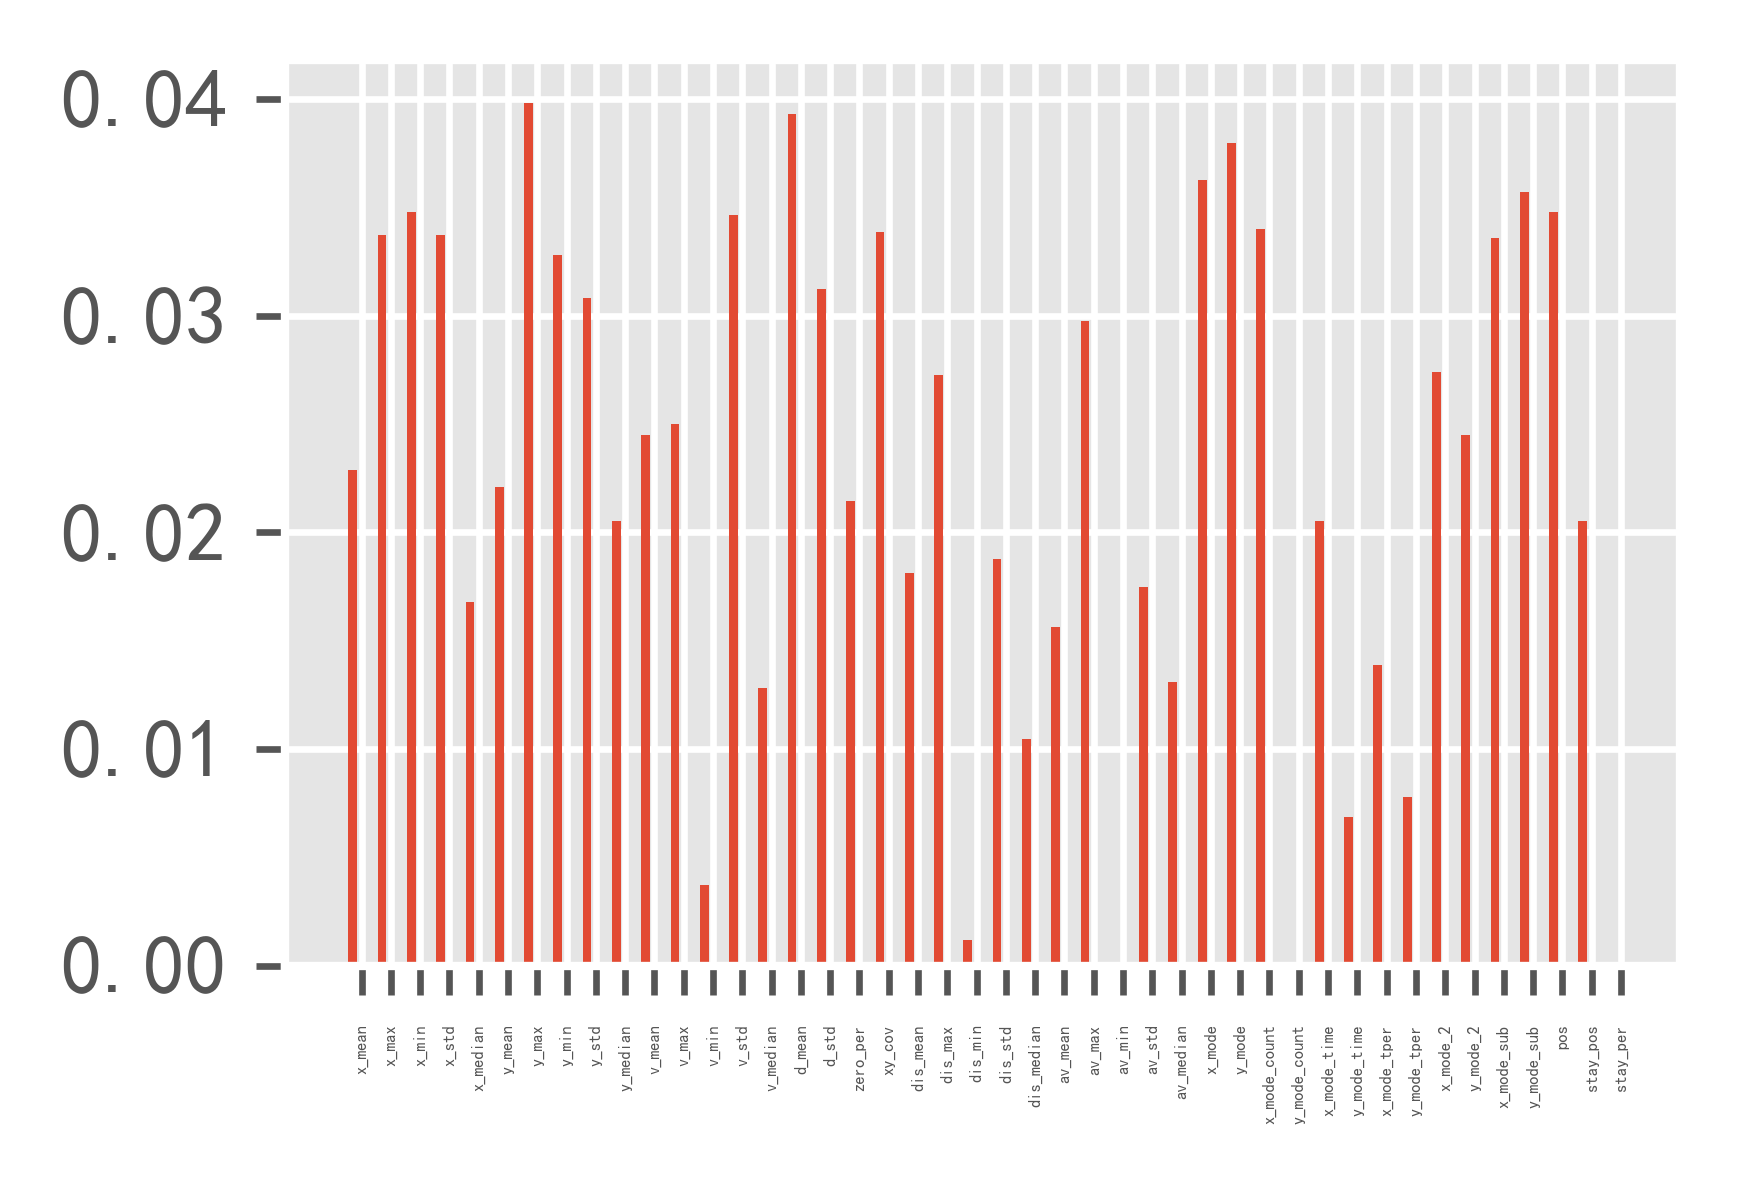

In [20]:
plt.figure(dpi=600,figsize=(3,2))
plt.bar(np.arange(len(features_name)), lgb_clf.feature_importances_/sum(lgb_clf.feature_importances_), 0.3)
plt.xticks(np.arange(len(features_name))+0.3, features_name, rotation=90, fontsize=2)
plt.show()

In [21]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(learning_rate=0.2,
                        n_estimators=100,
                        reg_lambda=0.1,
                        max_depth=6,
                        subsample=0.8, 
                        colsample_bytree=0.8)
xgb_clf.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 10, early_stopping_rounds=300)
val_pred = xgb_clf.predict(X_val)
print('train_F1:', f1_score(y_train, xgb_clf.predict(X_train), average='macro'))
print('val_F1:', f1_score(y_val, val_pred, average='macro'))
print(classification_report(y_val, val_pred))

[0]	validation_0-merror:0.194286
Will train until validation_0-merror hasn't improved in 300 rounds.
[10]	validation_0-merror:0.14
[20]	validation_0-merror:0.118571
[30]	validation_0-merror:0.107143
[40]	validation_0-merror:0.104286
[50]	validation_0-merror:0.101429
[60]	validation_0-merror:0.097143
[70]	validation_0-merror:0.095714
[80]	validation_0-merror:0.091429
[90]	validation_0-merror:0.091429
[99]	validation_0-merror:0.088571
train_F1: 0.9998422548054173
val_F1: 0.896801821027173
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       420
         1.0       0.85      0.83      0.84       177
         2.0       0.95      0.87      0.91       103

    accuracy                           0.91       700
   macro avg       0.91      0.89      0.90       700
weighted avg       0.91      0.91      0.91       700



In [22]:
xgb_result = xgb_clf.predict(X_test)
submission = pd.DataFrame(data={'id': list(range(7000, 9000)),
                   'result' : np.array(xgb_result, dtype=int)})
submission.to_csv('./data/submission_xgb.csv', index=False)

In [23]:
lgb_result = lgb_clf.predict(X_test)
submission = pd.DataFrame(data={'id': list(range(7000, 9000)),
                   'result' : np.array(lgb_result, dtype=int)})
submission.to_csv('./data/submission_lgb.csv', index=False)

In [24]:
xgb_val_pred = xgb_clf.predict_proba(X_val)
lgb_val_pred = lgb_clf.predict_proba(X_val)
best_weight = []
best_f1 = 0
for i in range(0, 100):
    pred = xgb_val_pred * i/100 + lgb_val_pred * (1 - i/100) 
    f1 = f1_score(y_val, np.argmax(pred, axis=-1), average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_weight = (i/100, 1 - i /100)
print(best_f1, best_weight)

0.9201797223435371 (0.0, 1.0)


In [25]:
xgb_1_pred = xgb_clf.predict_proba(np.concatenate([X_val, X_train[:300]], axis=0))
lgb_1_pred = lgb_clf.predict_proba(np.concatenate([X_val, X_train[:300]], axis=0))
best_weight = []
best_f1 = 0
for i in range(0, 100):
    pred = xgb_1_pred * i/100 + lgb_1_pred * (1 - i/100) 
    f1 = f1_score(np.concatenate([y_val, y_train[:300]], axis=0), np.argmax(pred, axis=-1), average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_weight = (i/100, 1 - i /100)
print(best_f1, best_weight)

0.9447119397255036 (0.0, 1.0)


In [26]:
lgb_test_prob = lgb_clf.predict_proba(X_test)
xgb_test_prob = xgb_clf.predict_proba(X_test)
result = np.argmax(0.61 * xgb_test_prob + 0.39 * lgb_test_prob, axis=-1)
submission = pd.DataFrame(data={'id': list(range(7000, 9000)),
                   'result' : np.array(result, dtype=int)})
submission.to_csv('./data/submission.csv', index=False)

In [27]:
submission['result'].value_counts()/2000

0    0.6355
1    0.2370
2    0.1275
Name: result, dtype: float64

In [28]:
train_df['type'].value_counts()/8000

0.0    0.545125
1.0    0.202625
2.0    0.127250
Name: type, dtype: float64

In [29]:
X_test[3]

array([ 6.16046658e+06,  6.20566339e+06,  6.15067481e+06,  1.57984712e+04,
        6.15087537e+06,  5.20243456e+06,  5.20624738e+06,  5.17472924e+06,
        7.20618917e+03,  5.20603100e+06,  1.13221176e+00,  1.00900000e+01,
        0.00000000e+00,  2.68519628e+00,  2.20000000e-01,  1.22242353e+02,
        1.19624570e+02,  2.02352941e-01, -1.06257137e+08,  3.38245548e+02,
        4.69498276e+03,  0.00000000e+00,  8.80042225e+02,  0.00000000e+00,
        5.45136328e-01,  5.46112330e+00,  0.00000000e+00,  1.39984687e+00,
        0.00000000e+00,  6.15087537e+06,  5.20603100e+06,  2.42000000e+02,
        2.42000000e+02,  2.55880000e+05,  2.55880000e+05,  9.88407801e-01,
        9.88407801e-01,  6.17910300e+06,  5.19835008e+06,  2.82276295e+04,
        7.68091965e+03,  4.25000000e+02,  8.60000000e+01,  2.02352941e-01])